In [25]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Cargamos nuestra tabla de datos con tres columnas x, y, y_error
arr = np.load('fit_exercise.npy')

In [27]:
x= arr[0]
y= arr[1]
z=arr[2]

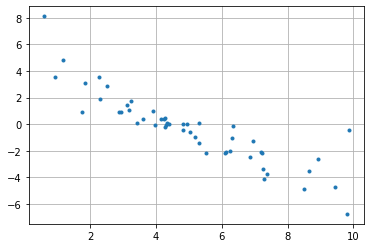

In [28]:
#Observamos los datos
plt.plot(arr[0], arr[1], 'o', label='Original data', markersize=3)
plt.grid()

In [29]:
# Fit a line, y = px + b, through some noisy data-points
A = np.vstack([arr[0], np.ones(len(arr[0]))]).T
p, b = np.linalg.lstsq(A, arr[1], rcond=None)[0]
# El valor de la pendiente de este ajuste es p y b su ordenada al origen
p, b

(-0.9821623517930426, 4.57785930375336)

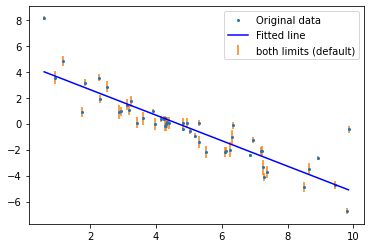

In [30]:
# Hacemos el ajuste lineal 

plt.plot(x, y, 'o', label='Original data', markersize=2)
plt.plot(arr[0], p*arr[0] + b, 'b', label='Fitted line')
plt.errorbar(arr[0], arr[1],yerr= arr[2],ls='',label='both limits (default)')
plt.legend()
plt.show()

In [31]:
Old=[-0.98,4.47,0.05]
New=np.zeros(3)

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [32]:
def muestreo(Old, x, y):
    
    #calculamos las propuestas de los parámetros de la recta de manera aleatoria
    New[0]=  np.random.normal(Old[0], Old[2])
    New[1]=  np.random.normal(Old[1], Old[2])
    New[2]=Old[2]

    #calculamos el posterior para el caso anterior y el nuevo (aleatorio)
    P_Old = -log_posterior(Old,x,y)
    P_New = -log_posterior(New,x,y)


    #si es mayor el nuevo posterior lo aceptamos
    if P_New>P_Old:

            Old= New
    
    #si no es mayor comparamos la división del posterior nuevo con el anterior con un número al azar entre cero y 1, si es mayor 
    #lo aceptamos       
    else:

            P_Ok = P_New / P_Old
            accept = np.random.rand() 

            if accept< P_Ok:
            # Update position
                Old= New
   
    return Old

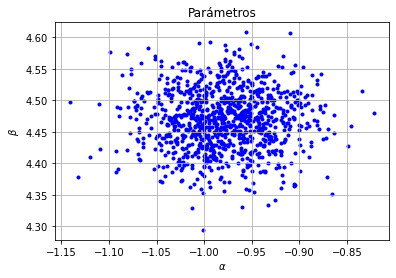

pendiente -0.9795579794075817
ordenada al origen 4.468269595009486


In [40]:
#graficamos los resultados de los parámetros
Oldie=[Old]
for i in range(1000):
    Oldie=np.append(Oldie,[muestreo(Old,x,y)],axis=0)

plt.grid()
plt.title('Parámetros')
plt.ylabel('$\\beta$')
plt.xlabel('$\\alpha$')
plt.scatter(Oldie[:,0],Oldie[:,1], marker='.', c='b')
plt.show()

#imprimimos la media de los resultados de los parámetros
print('pendiente '+str(np.mean(Oldie[:,0])))
print('ordenada al origen '+str(np.mean(Oldie[:,1])))

In [34]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """desde un conjunto de trazas, bin por numero de desviaciones estandar"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtener los índices para ordenar y desordenar la matriz aplanada
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, x, y, trace, scatter=False, **kwargs):
    """Graficar trazas y contornos"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')

def plot_MCMC_model(ax, x, y, trace):
    """Trazar el modelo lineal y los contornos 2sigma"""
    ax.plot(x, y, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(0, 12, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Trace la traza y el modelo juntos"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], x, y, trace, True, colors=colors)
    plot_MCMC_model(ax[1], x, y, trace)

In [35]:

import emcee
print(emcee.__version__)

2.2.1


In [36]:
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [37]:

# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [38]:

# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

Wall time: 2.13 s
done


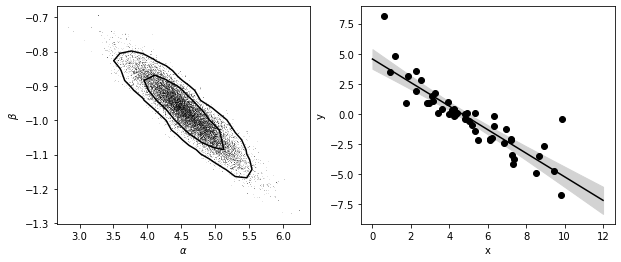

In [39]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(x, y, emcee_trace)